In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

def plot_columns_by_frequency(
    df, columns, 
    freq='D', 
    ignore_datetimes=False, 
    vertical_lines=None,
    line_text=None
):
    """
    Plot columns from a dataframe based on specified frequency.
    
    df: pandas DataFrame with a datetime index
    columns: list of columns to plot
    freq: frequency for plotting ('D' for day, 'W' for week, 'M' for month, 'Y' for year, or integer if ignore_datetimes=True)
    ignore_datetimes: if True, plots against a dummy index instead of datetimes
    vertical_lines: list of 2-tuple with datetimes indicating positions for vertical lines. 
                    The first datetime is plotted as a red line and the second as a green line.
    """

    if ignore_datetimes:
        if isinstance(freq, int):
            num_points = freq
        else:
            raise ValueError("When ignore_datetimes=True, freq should be an integer representing number of points.")
        
        indices = list(range(0, len(df), num_points))
        if indices[-1] != len(df):
            indices.append(len(df))

        for start, end in zip(indices[:-1], indices[1:]):
            subset = df.iloc[start:end]
            plt.figure(figsize=(10, 6))
            subset[columns].plot(ax=plt.gca(), marker='.', linestyle='--', secondary_y=True)
            
            if vertical_lines:
                for line in vertical_lines:
                    if df.index[start] <= line[0] <= df.index[end-1]:
                        idx_before = df.index.get_loc(line[0], method='ffill')
                        idx_after = df.index.get_loc(line[0], method='bfill')
                        pos = (idx_before + idx_after) / 2 - start
                        plt.axvline(x=pos, color='red')
                    
                    if df.index[start] <= line[1] <= df.index[end-1]:
                        idx_before = df.index.get_loc(line[1], method='ffill')
                        idx_after = df.index.get_loc(line[1], method='bfill')
                        pos = (idx_before + idx_after) / 2 - start
                        plt.axvline(x=pos, color='green')
            
            plt.title(f'Data from {subset.index[0]} to {subset.index[-1]}')
            plt.show()

    else:
        for sub_df in df.resample(freq):
            label, subset = sub_df
            if not subset.empty:
                plt.figure(figsize=(10, 6))
                subset[columns].plot(ax=plt.gca(), marker='.', linestyle='--', secondary_y=True)
                if vertical_lines:
                    for (line_idx, line) in enumerate(vertical_lines):
                        line_plotted=False
                        if subset.index[0] <= line[0] <= subset.index[-1]:
                            plt.axvline(x=line[0], color='red')
                            line_plotted=True
                        if subset.index[0] <= line[1] <= subset.index[-1]:
                            plt.axvline(x=line[1], color='green')
                            line_plotted=True
                        if line_plotted and len(line_text) == len(vertical_lines):
                            print(f'line:{line_idx}, reason:{line_text[line_idx]}')
                            
                plt.title(f'Data from {subset.index[0]} to {subset.index[-1]}')
                plt.show()

In [2]:
def is_start_of_daily_block(date_series):
    """
    Returns a boolean Series indicating if each date in the input Series is the 
    start of a new sequence of consecutive dates.

    :param date_series: Pandas Series with datetime objects.
    :return: Pandas Series of boolean values.
    """
    # Ensure the Series is sorted
    sorted_series = date_series.sort_values()

    # Calculate the difference in days between each date and the previous date
    day_diff = sorted_series.diff().dt.days

    # Mark True where the difference is greater than 1 day, indicating a new sequence
    is_start = day_diff > 1

    # Handle the first element
    if not is_start.empty:
        is_start.iloc[0] = True

    return is_start

In [3]:
def clean_data(df):
    df = df[(df['Extruder Pressure'] >= 0) & (df['Extruder Pressure'] < 50000)]
    
    return df

In [4]:
def get_machine_pauses(df, time_threshold=30, index=True):
    if index:
        time_diff = -1*(df.index.diff(-1).dt.total_seconds()/60)
        machine_pauses = df[time_diff > time_threshold].index
    else:
        time_diff = -1*(df['Date and Time'].diff(-1).dt.total_seconds()/60)
        machine_pauses = df[time_diff > time_threshold]['Date and Time']
    
    return machine_pauses

def calculate_time_difference(df, time_threshold=30):
    time_diff = -1*(df['Date and Time'].diff(-1).dt.total_seconds()/60)
    #time_diff = (df['Date and Time'].shift(-1) - df['Date and Time']).dt.total_seconds()/60

    return time_diff

In [5]:
import utils

In [6]:
def clean_extruder_data(extruder_data):
    
    extruder_data = extruder_data.drop(extruder_data.index[0])
    extruder_data = extruder_data.replace("<null>", None)
    
    extruder_data = extruder_data.dropna()

    # Convert the column to string type
    for column in extruder_data.columns:
        if column not in ["Date and Time", "AnomalyScore"]:
            extruder_data[column] = extruder_data[column].astype(str)
            #extruder_data[column] = extruder_data[column].str.replace("<null>", None)
            # Replace commas with an empty string
            extruder_data[column] = extruder_data[column].str.replace(",", "")

            # Convert the column back to numeric type, handling any conversion errors
            extruder_data[column] = pd.to_numeric(extruder_data[column], errors="coerce")
            
    extruder_data = extruder_data[(extruder_data['Extruder Pressure'] >= 0) & \
                              (extruder_data['Extruder Pressure'] < 50000)]

    extruder_data['Date and Time'] = pd.to_datetime(extruder_data['Date and Time'])
    
    return extruder_data

In [7]:
import pandas as pd
import re

columns_oi = ['Extruder Pressure']

ex1_data = clean_extruder_data( pd.read_csv("ex1-data.csv") )

/tmp/ipykernel_54616/3652090139.py:6: DtypeWarning: Columns (2,3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  ex1_data = clean_extruder_data( pd.read_csv("ex1-data.csv") )


In [8]:

ex1_data = ex1_data.groupby('Date and Time').mean()

# resampling every 5 minutes instead of 1 minute

ex1_resampled = ex1_data.resample('5T').mean()

In [9]:

ex1_data['Date and Time'] = ex1_data.index
ex1_pauses = get_machine_pauses(ex1_data, time_threshold=15, index=False)

pauses = ex1_pauses

In [10]:
ex1_data.head()

,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%),Date and Time
Date and Time,,,,,,,,,
2022-11-08 08:27:00,6147.49,28.76,25.0,358.23,64.45,3.14,0.88,75.7,2022-11-08 08:27:00
2022-11-08 08:28:00,6313.45,28.76,25.0,358.23,64.52,3.14,0.86,75.7,2022-11-08 08:28:00
2022-11-08 08:29:00,6396.43,28.76,25.0,343.51,64.66,3.14,0.86,75.7,2022-11-08 08:29:00
2022-11-08 08:30:00,6396.43,28.76,25.0,343.51,64.66,3.14,0.90,75.7,2022-11-08 08:30:00
2022-11-08 08:31:00,5928.85,28.76,25.0,343.51,63.80,3.14,0.90,75.7,2022-11-08 08:31:00


In [11]:
def hours_since_last_pause(time, pauses):
    return (time - pauses[pauses <= time].max()).total_seconds()/3600

def hours_to_next_pause(time, pauses):
    return (pauses[pauses >= time].min() - time).total_seconds()/3600

In [12]:
%%time
#from tqdm import tqdm

ex1_data['hours_since_last_pause'] = ex1_data.index.to_series().apply(
    lambda x : hours_since_last_pause(x, pauses)
)
ex1_data['hours_to_next_pause'] = ex1_data.index.to_series().apply(
    lambda x : hours_to_next_pause(x, pauses)
)

CPU times: user 1min 6s, sys: 24.2 ms, total: 1min 6s
Wall time: 1min 6s


In [13]:
# Extruder Pressure - for rolling
# for lagged variables - Extruder Die Temp, Extruder Thrust

#test = ex1_data.iloc[:1000][['Extruder Pressure']]


for time_window in ['5T', '15T', '30T', '1H', '2H', '3H', '6H', '12H']:
    if 'T' in time_window:
        label_append = time_window.replace('T', 'min')
    elif 'H' in time_window:
        label_append = time_window.replace('H', 'hour')

    col_label = 'pressure-' + label_append + '_avg'
    ex1_data[col_label] = ex1_data['Extruder Pressure'].rolling(time_window).mean()

In [14]:
ex1_data.head()

,Extruder Pressure,Screw Speed Output,Screw Speed,Extruder Die Temp,Extruder Thrust,Feed Screw Current (Amps),Discharge Conveyor Current (Amps),Discharge Conveyor Speed (%),Date and Time,hours_since_last_pause,hours_to_next_pause,pressure-5min_avg,pressure-15min_avg,pressure-30min_avg,pressure-1hour_avg,pressure-2hour_avg,pressure-3hour_avg,pressure-6hour_avg,pressure-12hour_avg
Date and Time,,,,,,,,,,,,,,,,,,,
2022-11-08 08:27:00,6147.49,28.76,25.0,358.23,64.45,3.14,0.88,75.7,2022-11-08 08:27:00,NaN,820.283333,6147.49,6147.49,6147.49,6147.49,6147.49,6147.49,6147.49,6147.49
2022-11-08 08:28:00,6313.45,28.76,25.0,358.23,64.52,3.14,0.86,75.7,2022-11-08 08:28:00,NaN,820.266667,6230.47,6230.47,6230.47,6230.47,6230.47,6230.47,6230.47,6230.47
2022-11-08 08:29:00,6396.43,28.76,25.0,343.51,64.66,3.14,0.86,75.7,2022-11-08 08:29:00,NaN,820.250000,6285.79,6285.79,6285.79,6285.79,6285.79,6285.79,6285.79,6285.79
2022-11-08 08:30:00,6396.43,28.76,25.0,343.51,64.66,3.14,0.90,75.7,2022-11-08 08:30:00,NaN,820.233333,6313.45,6313.45,6313.45,6313.45,6313.45,6313.45,6313.45,6313.45
2022-11-08 08:31:00,5928.85,28.76,25.0,343.51,63.80,3.14,0.90,75.7,2022-11-08 08:31:00,NaN,820.216667,6236.53,6236.53,6236.53,6236.53,6236.53,6236.53,6236.53,6236.53


In [15]:
variables_to_lag = ['Extruder Die Temp', 'Extruder Thrust',
                    'Screw Speed Output']

colname_map = {
    'Extruder Die Temp' : 'die_temp-',
    'Extruder Thrust' : 'thrust-',
    'Screw Speed Output' : 'screw_speed_output-',
}
#ex_num = 1

#print(ex_num, ex1_data.shape)
for time_window in ['5T', '15T', '1H', '3H']:
    if 'T' in time_window:
        label_append = time_window.replace('T', 'min')
    elif 'H' in time_window:
        label_append = time_window.replace('H', 'hour')
    for lagvar in variables_to_lag:
        col_label = colname_map[lagvar] + label_append + '_avg'
        ex1_data[col_label] = \
            ex1_data[lagvar].rolling(time_window).mean()

<Axes: xlabel='Date and Time'>

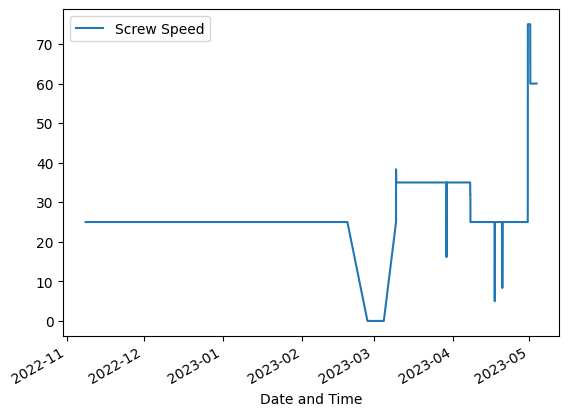

In [16]:
ex1_data[['Screw Speed']].plot()

<Axes: xlabel='Date and Time'>

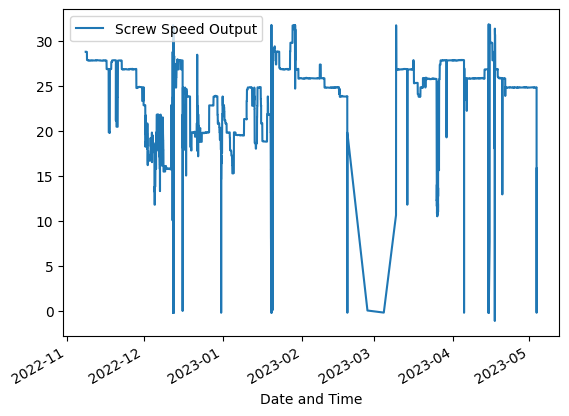

In [17]:
ex1_data[['Screw Speed Output']].plot()

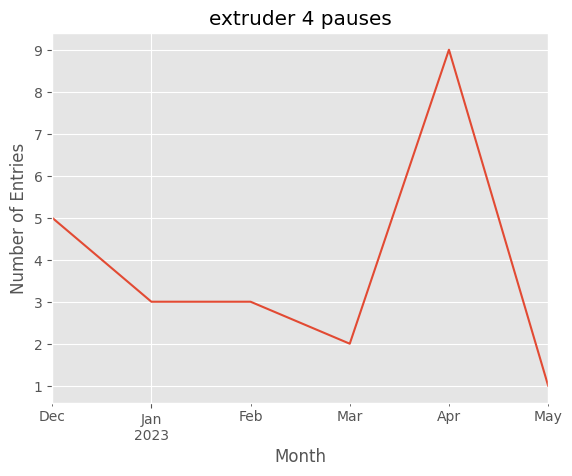

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

def plot_entries_by_frequency(
    datetime_series, 
    title='Number of entries by month',
    freq='M',
    kind='line',
):
    monthly_counts = datetime_series.groupby(pd.Grouper(freq=freq)).count()

    monthly_counts.plot(kind=kind)
    plt.xlabel('Month')
    plt.ylabel('Number of Entries')
    plt.title(title)
    plt.grid(True)
    plt.show()

plot_entries_by_frequency(ex1_pauses, title='extruder 4 pauses')

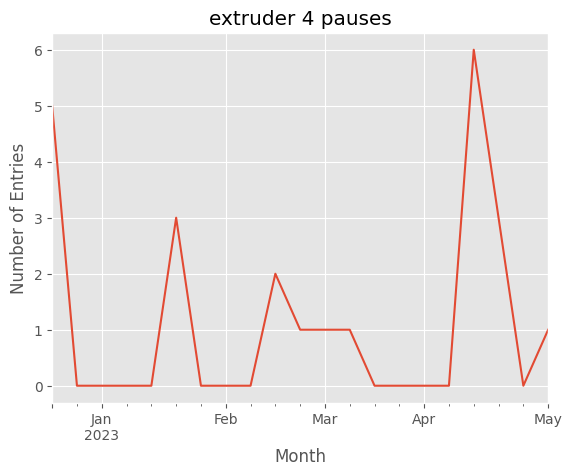

In [19]:

plot_entries_by_frequency(ex1_pauses, title='extruder 4 pauses', freq='W')

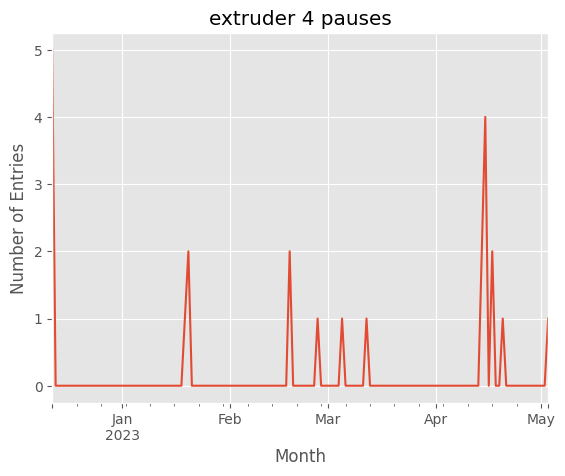

In [20]:

plot_entries_by_frequency(
    ex1_pauses, 
    title='extruder 4 pauses', freq='D'
)

In [21]:
min_datetime = pauses.min() - pd.Timedelta(days=7)
max_datetime = pauses.max()

time_mask = (ex1_data.index >= min_datetime) \
            & (ex1_data.index <= max_datetime)
ex1_data = ex1_data[time_mask]

redundancy_mask = (ex1_data['hours_since_last_pause'] >= 3) \
                  | (ex1_data['hours_to_next_pause'] >= 3)
ex1_data = ex1_data[redundancy_mask]

In [22]:
# set up classifier variables -
# whether there is a pause within 
# {1 minute, 5 minutes, 10 minutes, 15 minutes, 30 minutes,
#  1 hour, 2 hours, 3 hours, 6 hours, 12 hours, 24 hours}

stop_target_to_hours_map = {
#    '1min' : 1/60,
    '5min' : 5/60,
    '10min': 10/60,
    '15min': 15/60,
    '30min': 30/60,
    '1hour': 1,
    '2hour': 2,
    '3hour': 3,
    '6hour':6,
    '12hour':12,
    '24hour':24,
}


for window in stop_target_to_hours_map:
    ex1_data[f'{window}_stop'] = \
        ex1_data['hours_to_next_pause'] < stop_target_to_hours_map[window]

In [23]:
target_features = [s+ '_stop' for s in stop_target_to_hours_map.keys()]
input_features = [
    'Screw Speed Output',
    'Screw Speed',
    'Extruder Die Temp',
    'Extruder Thrust',
    'Feed Screw Current (Amps)',
    'Discharge Conveyor Current (Amps)',
    'Discharge Conveyor Speed (%)',
    'pressure-5min_avg',
    'pressure-15min_avg',
    'pressure-30min_avg',
    'pressure-1hour_avg',
    'pressure-2hour_avg',
    'pressure-3hour_avg',
    'die_temp-5min_avg',
    'thrust-5min_avg',
    'die_temp-15min_avg',
    'thrust-15min_avg',
    'die_temp-1hour_avg',
    'thrust-1hour_avg',
    'die_temp-3hour_avg',
    'thrust-3hour_avg',
]

In [24]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

def balance_dataset(X, y, over_sample_ratio=0.1, under_sample_ratio=0.5):
    """
    Balances the dataset by over-sampling the minority class and under-sampling the majority class.

    :param X: Feature set.
    :param y: Labels.
    :param over_sample_ratio: Ratio of the number of samples in the minority class after resampling
                              to the number of samples in the majority class before resampling.
    :param under_sample_ratio: Ratio of the number of samples in the majority class after resampling
                               to the number of samples in the minority class after over-sampling.

    :return: Balanced features and labels.
    """
    
    # Define the resampling strategy
    over = SMOTE(sampling_strategy=over_sample_ratio)
    under = RandomUnderSampler(sampling_strategy=under_sample_ratio)
    steps = [('o', over), ('u', under)]
    pipeline = Pipeline(steps=steps)

    # Transform the dataset
    X_balanced, y_balanced = pipeline.fit_resample(X, y)

    return X_balanced, y_balanced

In [25]:
model_input = ex1_data[input_features]
model_output = ex1_data[target_features]

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns

import time
import pickle

# Load a dataset (Iris dataset as an example)
#data = load_iris()
X = model_input.values

print('input variables:')
for var in model_input.columns:
    print(var)

# Define the models to test
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'MLP' : MLPClassifier(hidden_layer_sizes=(16, 32), max_iter=1000)
}

# Dictionary to hold the results
results = {}
output_models = {}

saved_processed_data = {}

# Iterate over the models, fit, and evaluate them
for targ in target_features:
    if targ not in results:
        start_time = time.time()
        
        results[targ] = dict()
        output_models[targ] = dict()
    y = model_output[targ].values
    
    # Split the data into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    n_true = np.sum((Y_train == 1))
    n_false = np.sum((Y_train == 0))
    print(f'original true samples: {n_true}, original false samples: {n_false}')
    try:
        X_train, Y_train = balance_dataset(X_train, Y_train)
    except Exception as e:
        print(f'errored on balanced dataset: {e}, using raw dataset')
    
    saved_processed_data[targ] = (X_train, Y_train)
    
    n_true = np.sum((Y_train == 1))
    n_false = np.sum((Y_train == 0))
    print(f'balanced true samples: {n_true}, balanced false samples: {n_false}')
    for name, model in models.items():
        print()
        print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
        print(f'results for target: {targ}, model: {name}')
        model.fit(X_train, Y_train)
        output_models[targ][name] = model
        
        predictions = model.predict(X_test)
        
        # Compute the confusion matrix
        conf_matrix = confusion_matrix(Y_test, predictions)

        accuracy = accuracy_score(Y_test, predictions)
        cross_val = cross_val_score(model, X, y, cv=5)
        results[targ][name] = {'Accuracy': accuracy, 'Cross-Val Mean': np.mean(cross_val),
                              'Confusion_Matrix' : conf_matrix}
        
        
        print(results[targ][name])
        print('--------------------------------------')
        
        duration = time.time() - start_time
        print(f"Run time: {duration / 60:.2f} minutes")
        print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
        print('--------------------------------------')
    print()
    print()
    
with open('models_no_screw_speed_ex1.pkl', 'wb') as f:
    pickle.dump((output_models, results), f)


input variables:
Screw Speed Output
Screw Speed
Extruder Die Temp
Extruder Thrust
Feed Screw Current (Amps)
Discharge Conveyor Current (Amps)
Discharge Conveyor Speed (%)
pressure-5min_avg
pressure-15min_avg
pressure-30min_avg
pressure-1hour_avg
pressure-2hour_avg
pressure-3hour_avg
die_temp-5min_avg
thrust-5min_avg
die_temp-15min_avg
thrust-15min_avg
die_temp-1hour_avg
thrust-1hour_avg
die_temp-3hour_avg
thrust-3hour_avg
original true samples: 14, original false samples: 104780
balanced true samples: 10478, balanced false samples: 20956

Current Time: 22:44:35
results for target: 5min_stop, model: Logistic Regression


/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

{'Accuracy': 0.950570632466888, 'Cross-Val Mean': 0.9989465130208472, 'Confusion_Matrix': array([[24900,  1294],
       [    1,     4]])}
--------------------------------------
Run time: 0.10 minutes
Current Time: 22:44:41
--------------------------------------

Current Time: 22:44:41
results for target: 5min_stop, model: Random Forest
{'Accuracy': 0.9999618306042215, 'Cross-Val Mean': 0.9628688082900092, 'Confusion_Matrix': array([[26193,     1],
       [    0,     5]])}
--------------------------------------
Run time: 1.14 minutes
Current Time: 22:45:43
--------------------------------------

Current Time: 22:45:43
results for target: 5min_stop, model: Support Vector Machine
{'Accuracy': 0.9711439367914806, 'Cross-Val Mean': 0.9998549542563001, 'Confusion_Matrix': array([[25439,   755],
       [    1,     4]])}
--------------------------------------
Run time: 1.59 minutes
Current Time: 22:46:10
--------------------------------------

Current Time: 22:46:10
results for target: 5min_st

/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/michael/.virtualenvs/default/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#

{'Accuracy': 0.9423260429787397, 'Cross-Val Mean': 0.9996412024346322, 'Confusion_Matrix': array([[24681,  1508],
       [    3,     7]])}
--------------------------------------
Run time: 0.10 minutes
Current Time: 22:51:19
--------------------------------------

Current Time: 22:51:19
results for target: 10min_stop, model: Random Forest
{'Accuracy': 0.9999618306042215, 'Cross-Val Mean': 0.9911598971295301, 'Confusion_Matrix': array([[26189,     0],
       [    1,     9]])}
--------------------------------------
Run time: 1.29 minutes
Current Time: 22:52:31
--------------------------------------

Current Time: 22:52:31
results for target: 10min_stop, model: Support Vector Machine
{'Accuracy': 0.9827856025039123, 'Cross-Val Mean': 0.9996412024346322, 'Confusion_Matrix': array([[25742,   447],
       [    4,     6]])}
--------------------------------------
Run time: 1.82 minutes
Current Time: 22:53:03
--------------------------------------

Current Time: 22:53:03
results for target: 10mi

In [ ]:
target_features = [s+ '_stop' for s in stop_target_to_hours_map.keys()]
input_features = [
    'Screw Speed Output',
    'Screw Speed',
    'Extruder Die Temp',
    'Extruder Thrust',
    'Feed Screw Current (Amps)',
    'Discharge Conveyor Current (Amps)',
    'Discharge Conveyor Speed (%)',
    'pressure-5min_avg',
    'pressure-15min_avg',
    'pressure-30min_avg',
    'pressure-1hour_avg',
    'pressure-2hour_avg',
    'pressure-3hour_avg',
    'die_temp-5min_avg',
    'thrust-5min_avg',
    'screw_speed_output-5min_avg',
    'die_temp-15min_avg',
    'thrust-15min_avg',
    'screw_speed_output-15min_avg',
    'die_temp-1hour_avg',
    'thrust-1hour_avg',
    'screw_speed_output-1hour_avg',
    'die_temp-3hour_avg',
    'thrust-3hour_avg',
    'screw_speed_output-3hour_avg',
]

In [ ]:
model_input = ex1_data[input_features]
model_output = ex1_data[target_features]

In [ ]:
# Load a dataset (Iris dataset as an example)
#data = load_iris()
X = model_input.values

print('input variables:')
for var in model_input.columns:
    print(var)
#y = model_output.values

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the models to test
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'MLP' : MLPClassifier(hidden_layer_sizes=(16, 32), max_iter=1000)
}

# Dictionary to hold the results
results = {}
output_models = {}

saved_processed_data = {}

# Iterate over the models, fit, and evaluate them
for targ in target_features:
    if targ not in results:
        start_time = time.time()
        
        results[targ] = dict()
        output_models[targ] = dict()
    y = model_output[targ].values
    
    # Split the data into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    n_true = np.sum((Y_train == 1))
    n_false = np.sum((Y_train == 0))
    print(f'original true samples: {n_true}, original false samples: {n_false}')
    try:
        X_train, Y_train = balance_dataset(X_train, Y_train)
    except Exception as e:
        print(f'errored on balanced dataset: {e}, using raw dataset')
    
    saved_processed_data[targ] = (X_train, Y_train)
    
    n_true = np.sum((Y_train == 1))
    n_false = np.sum((Y_train == 0))
    print(f'balanced true samples: {n_true}, balanced false samples: {n_false}')
    for name, model in models.items():
        print()
        print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
        print(f'results for target: {targ}, model: {name}')
        model.fit(X_train, Y_train)
        output_models[targ][name] = model
        
        predictions = model.predict(X_test)
        
        # Compute the confusion matrix
        conf_matrix = confusion_matrix(Y_test, predictions)

        # Visualize the confusion matrix
        accuracy = accuracy_score(Y_test, predictions)
        cross_val = cross_val_score(model, X, y, cv=5)
        results[targ][name] = {'Accuracy': accuracy, 'Cross-Val Mean': np.mean(cross_val),
                              'Confusion_Matrix' : conf_matrix}
        
        
        print(results[targ][name])
        print('--------------------------------------')
        
        duration = time.time() - start_time
        print(f"Run time: {duration / 60:.2f} minutes")
        print(f"Current Time: {time.strftime('%H:%M:%S', time.localtime())}")
        print('--------------------------------------')
        
    results_df = pd.DataFrame(results[targ]).T

    print()
    print()
    
with open('models_with_screw_speed_ex1.pkl', 'wb') as f:
    pickle.dump((output_models, results), f)